# Model: ARIMA, Stock Token: ITD, Train/Test: 70/30
- Dataset: 1313 rows x 7 columns (01/03/2019 - 01/06/2024)
----
### Model evaluation (Test set)
- RMSE: 37150.39
- MAE: 37112.13
- MAPE: 4.93 %

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import joblib
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

## 1. Data preprocessing

In [26]:
stocks = ["FPT", "CMG", "ITD"]  # Stock token in dataset
ratios=[0.8,0.7,0.9]
targets = ["close"]  # The closing price is the target we want to predict
train_test_split = ["82", "73", "91"]  # Percent of for train, test

project_path = os.getcwd()
data_path = os.path.join(project_path, "data\\")
project_path_optimize = os.path.join(project_path, "optimize\\")
processing_output = os.path.join(project_path, "processing_output\\")

os.makedirs(processing_output, exist_ok=True)

T = 60  # ----> lookback
TF = 1  # ----> predict
NFeature = 1  # ----> feautures

data_set = {1: "train", 2: "test"}
stock_id =2 # 0: FPT, 1: CMG, 2: ITD
n_split = 1 # 0: 82, 1: 73, 2: 91

In [27]:
def getData(index):
    df = pd.read_csv(f"../../Dataset/{stocks[index]}_stock.csv", index_col="time")

    return df[[targets[0]]]

In [28]:
df = getData(stock_id)
df.head()

,close
time,
2019-03-01,6900
2019-03-04,7100
2019-03-05,7100
2019-03-06,7170
2019-03-07,7170


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1313 entries, 2019-03-01 to 2024-05-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   close   1313 non-null   int64
dtypes: int64(1)
memory usage: 20.5+ KB


In [30]:
df.describe()

,close
count,1313.000000
mean,10160.894897
std,3002.802575
min,5320.000000
25%,7550.000000
50%,10040.000000
75%,11650.000000
max,21430.000000


In [31]:
df.isna().sum()

close    0
dtype: int64

Preprocess

In [32]:
def normalizationMinMax(df, set):
    """
  Params:
      * df -- DataFrame:        Dataframe need to be scaled
      * set -- int:  A string to recognize that dataset is train/test
  Returns:
      * scaler:     used for future inverse-transform
      * df_scaled:  df after normalization

  """
    scaler = MinMaxScaler()

    processes_folder = f"{processing_output}/{stocks[stock_id]}"
    os.makedirs(processes_folder, exist_ok=True)

    if set == "train": 
        scaler.fit(df)
        series = scaler.transform(df)
        #neu du lieu la tap train, ham se tien hanh fit() va transform() dua tren tap train
        df_scaled = pd.DataFrame(data=series, columns = df.columns)
        out_scaler_file = os.path.join(processing_output, f"{stocks[stock_id]}\{train_test_split[n_split]}\{targets[0]}_train_scalerMinMaxNorm.save")
        os.makedirs(os.path.dirname(out_scaler_file), exist_ok=True)
        joblib.dump(scaler, out_scaler_file)
        # sau do luu lai scaler de su dung cho cac tap test
        print(os.path.exists(out_scaler_file))

    else:
        #neu du lieu la tap test ham se su dung scaler da duoc fit() tu tap train
        scaler = joblib.load(os.path.join(processing_output, f"{stocks[stock_id]}\{train_test_split[n_split]}\{targets[0]}_train_scalerMinMaxNorm.save"))
        series = scaler.transform(df)
        df_scaled = pd.DataFrame(data = series, columns = df.columns)

    out_file = os.path.join(processing_output, f"{stocks[stock_id]}\{train_test_split[n_split]}\{targets[0]}_{set}_scaler.xlsx")
    
    df_scaled.to_excel(out_file, float_format='%.5f')
    print(out_file)
    return df_scaled,scaler

## 2. Train model

In [33]:
n_observations = df.shape[0]

train_ratio = ratios[n_split]
test_ratio = 1 - train_ratio

train_size = int(n_observations*train_ratio)
test_size = int(n_observations*test_ratio)

train = df[0:train_size]
test = df[train_size:]

In [34]:
# MinMaxScaler
train_scaled, scaler = normalizationMinMax(train, "train")
test_scaled, scaler = normalizationMinMax(test, "test")
train_scaled.head()

True
d:\VSCode\IS403_O22_HTCL_8\Model\ARIMA\processing_output\ITD\73\close_train_scaler.xlsx
d:\VSCode\IS403_O22_HTCL_8\Model\ARIMA\processing_output\ITD\73\close_test_scaler.xlsx


,close
0,0.098076
1,0.110490
2,0.110490
3,0.114836
4,0.114836


ARIMA

In [35]:
#load scaler
scaler = joblib.load(os.path.join(f"{processing_output}/{stocks[stock_id]}/{train_test_split[n_split]}", f"{targets[0]}_train_scalerMinMaxNorm.save"))

In [36]:
def getDataExcel(subset="train"):
    df = pd.read_excel(
        f"./processing_output/{stocks[stock_id]}/{train_test_split[n_split]}/{targets[0]}_{subset}_scaler.xlsx"
    )
    df.drop(columns=["Unnamed: 0"], inplace=True)
    return df

Model

In [37]:
def buildModel(df):
    arimaModel = pm.auto_arima(
        df,
        test="adf",  # use adftest to find optimal 'd'
        trace=True,
        max_p=10,
        max_q=10,
        error_action="ignore",
        suppress_warnings=True,
        seasonal=False,
        n_fits=100,
        alpha=0.01,
        maxiter=50,
        stepwise=False,
    )
    return arimaModel

In [38]:
df_train = getDataExcel(subset="train")
df_test = getDataExcel(subset="test")

In [39]:
model = buildModel(df_train)
print(model.summary())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4658.105, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4669.951, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4676.858, Time=0.25 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-4674.928, Time=0.68 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-4674.540, Time=0.94 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-4678.393, Time=0.56 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4667.111, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4677.481, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4674.991, Time=0.22 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-4673.104, Time=0.91 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-4677.025, Time=0.75 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4676.686, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4674.774, Time=0.36 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4672.932, Time=0.49 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-4674.393, Time=1.33

## 2. Model evaluation

In [40]:
def evaluate(df, title, actual, predict):
    rmse = np.sqrt(mean_squared_error(actual, predict))
    mae = mean_absolute_error(actual, predict)
    mape = mean_absolute_percentage_error(actual, predict) * 100

    df[f"rmse_{title}"].append(rmse)
    df[f"mae_{title}"].append(mae)
    df[f"mape_{title}"].append(mape)
    return df

In [41]:
metrics_df = {
    "rmse_train": [],
    "mae_train": [],
    "mape_train": [],
    "rmse_test": [],
    "mae_test": [],
    "mape_test": []
}

# Dự đoán trên tập huấn luyện
y_pred_train = model.predict_in_sample()
# inverse transform TRAIN (tra ve kieu truoc khi scale)
pred_train = scaler.inverse_transform(np.array(y_pred_train).reshape(1, -1))
y_actual_train = scaler.inverse_transform(df_train)

# Dự đoán trên tập kiểm thử
y_pred_test = model.predict(n_periods=len(df_test))
# inverse transform TEST (tra ve kieu truoc khi scale)
pred_test = scaler.inverse_transform(np.array(y_pred_test).reshape(1, -1))
y_actual_test = scaler.inverse_transform(df_test)

# cap nhat model voi tap test
model.update(df_test)


metrics_df = evaluate(metrics_df, "train", y_actual_train, pred_train.squeeze())
metrics_df = evaluate(metrics_df, "test", y_actual_test, pred_test.squeeze())

metrics_df = pd.DataFrame(metrics_df)
metrics_folder = f"metrics\{stocks[stock_id]}"
os.makedirs(metrics_folder, exist_ok=True)
metrics_df.to_excel(f"{metrics_folder}\ARIMA_{train_test_split[n_split]}.xlsx")

print("------------------ Evaluation model ---------------------")
metrics_df

------------------ Evaluation model ---------------------


,rmse_train,mae_train,mape_train,rmse_test,mae_test,mape_test
0,306.889185,196.569044,1.833939,1205.20893,1073.681758,9.719168


In [42]:
y_actual_train

array([[ 6900.0688],
       [ 7099.9939],
       [ 7099.9939],
       [ 7170.0724],
       [ 7170.0724],
       [ 7230.0016],
       [ 7659.9775],
       [ 8189.0299],
       [ 8479.9765],
       [ 8420.0473],
       [ 8509.9411],
       [ 8379.9334],
       [ 8219.9611],
       [ 7959.9457],
       [ 8150.0437],
       [ 7890.0283],
       [ 7559.9344],
       [ 7760.0206],
       [ 8020.036 ],
       [ 7819.9498],
       [ 7789.9852],
       [ 7730.056 ],
       [ 7789.9852],
       [ 7819.9498],
       [ 8150.0437],
       [ 8150.0437],
       [ 8020.036 ],
       [ 7959.9457],
       [ 7890.0283],
       [ 7990.0714],
       [ 8020.036 ],
       [ 7819.9498],
       [ 7760.0206],
       [ 7559.9344],
       [ 7689.9421],
       [ 7819.9498],
       [ 7559.9344],
       [ 7630.0129],
       [ 7819.9498],
       [ 7689.9421],
       [ 7630.0129],
       [ 7559.9344],
       [ 7429.9267],
       [ 7460.0524],
       [ 7959.9457],
       [ 7500.0052],
       [ 7460.0524],
       [ 7559

In [43]:
pred_train

array([[ 5323.12150118,  6903.19030124,  7125.55559303,  7080.01501825,
         7180.22417874,  7159.6161623 ,  7255.66732603,  7704.10933241,
         8219.05360873,  8454.62845096,  8372.87993143,  8542.97159333,
         8376.28095191,  8236.32848984,  7940.31387142,  8227.71518533,
         7827.19256261,  7554.68688746,  7798.77803057,  8063.24265754,
         7747.02138274,  7792.28779491,  7734.93246886,  7829.34060311,
         7798.5095371 ,  8203.65879559,  8104.11281224,  8013.4522204 ,
         7954.56154591,  7919.78155417,  8008.90413258,  8014.43298822,
         7792.91192448,  7771.61694612,  7548.42123042,  7740.78106397,
         7810.75038276,  7522.86776701,  7650.96237549,  7848.21971171,
         7666.01021781,  7618.80619898,  7565.64390145,  7439.55670619,
         7470.65078394,  8027.19454341,  7383.60522711,  7504.61167581,
         7561.81927871,  7754.36883936,  7595.19012834,  7568.93771605,
         7567.94581393,  7576.1128145 ,  7488.38595233,  7510.31

## 3. Predict the closing price in next 30/60/90 days

In [44]:
# Predict for the next 30 days
y_pred_future_30 = model.predict(n_periods=30)
# inverse transform FUTURE (return to the type before scaling)
pred_future_30 = scaler.inverse_transform(np.array(y_pred_future_30).reshape(1, -1))

# Predict for the next 60 days
y_pred_future_60 = model.predict(n_periods=60)
# inverse transform FUTURE (return to the type before scaling)
pred_future_60 = scaler.inverse_transform(np.array(y_pred_future_60).reshape(1, -1))

# Predict for the next 90 days
y_pred_future_90 = model.predict(n_periods=90)
# inverse transform FUTURE (return to the type before scaling)
pred_future_90 = scaler.inverse_transform(np.array(y_pred_future_90).reshape(1, -1))

In [45]:
pred_future_30

array([[12715.27978211, 12721.17230088, 12743.06661846, 12737.53899449,
        12757.03820668, 12761.40717084, 12765.776135  , 12770.14509917,
        12774.51406333, 12778.8830275 , 12783.25199166, 12787.62095582,
        12791.98991999, 12796.35888415, 12800.72784831, 12805.09681248,
        12809.46577664, 12813.83474081, 12818.20370497, 12822.57266913,
        12826.9416333 , 12831.31059746, 12835.67956163, 12840.04852579,
        12844.41748995, 12848.78645412, 12853.15541828, 12857.52438245,
        12861.89334661, 12866.26231077]])

### Plotting the data

In [46]:
train_range = range(0, len(y_actual_train.squeeze()))
test_range = range(
    train_range[-1] + 1, train_range[-1] + 1 + len(y_actual_test.squeeze())
)
future_range_30 = range(
    test_range[-1] + 1, test_range[-1] + 1 + len(pred_future_30.squeeze())
)
future_range_60 = range(
    test_range[-1] + 1, test_range[-1] + 1 + len(pred_future_60.squeeze())
)
future_range_90 = range(
    test_range[-1] + 1, test_range[-1] + 1 + len(pred_future_90.squeeze())
)

In [47]:
def draw_plot(fureture_days, days):
    plt.figure(figsize=(10, 6))

    # Plot train data
    plt.plot(
        [*train_range],
        y_actual_train.squeeze(),
        label="Actual Train",
    )
    plt.plot(
        [*train_range],
        pred_train.squeeze(),
        label="Predict Train",
        linestyle="dotted",
    )

    # Plot test data
    plt.plot([*test_range], y_actual_test.squeeze(), label="Actual Test")
    plt.plot(
        [*test_range],
        pred_test.squeeze(),
        label="Predict Test",
        linestyle="dotted",
    )

    # Next xx days
    future_range = range(
        test_range[-1] + 1, test_range[-1] + 1 + len(fureture_days.squeeze())
    )
    plt.plot(
        [*future_range],
        fureture_days.squeeze(),
        label=f"Next {days} days",
        linestyle="dotted",
    )

    plt.legend()
    plt.title(f"ARIMA {stocks[stock_id]} -- {train_test_split[n_split]}")
    plt.show()

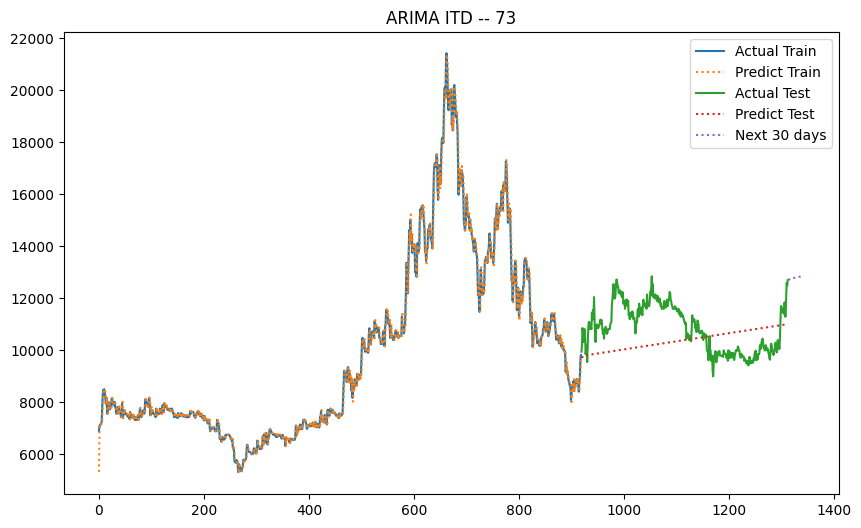

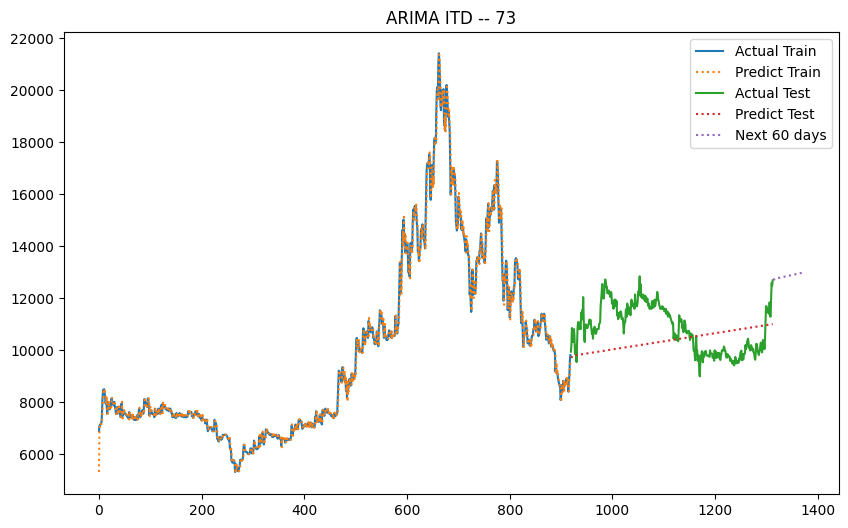

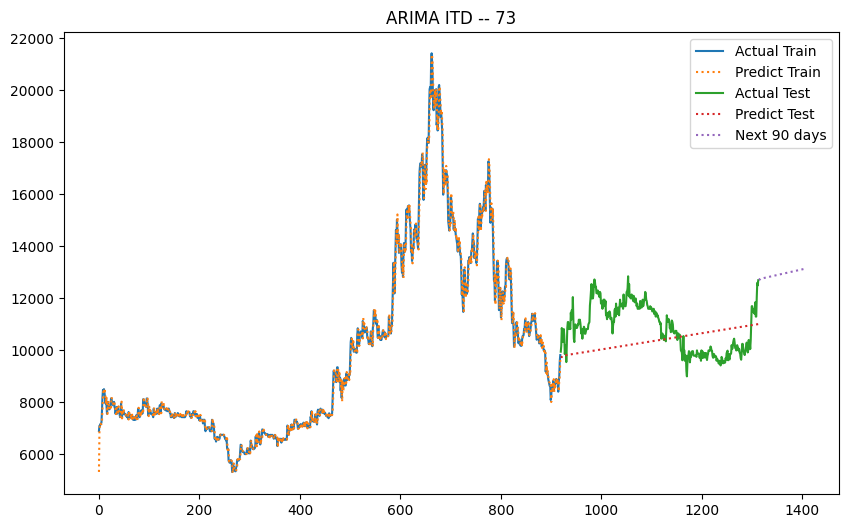

In [48]:
draw_plot(pred_future_30, 30)
draw_plot(pred_future_60, 60)
draw_plot(pred_future_90, 90)